# dataloaders

> Bundle trn/val/test datasets together, and add helpful functionality for viewing data

In [ ]:
#| hide
#|default_exp dataloaders

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from isaacai.utils import *
from matplotlib import pyplot as plt

from fastcore.all import *
import torch
from torch import nn
from torch import Tensor
from datasets import load_dataset
from torch.utils.data import DataLoader
import pandas as pd 
import numpy as np
from datasets import Dataset

import torchvision.transforms.functional as TF,torch.nn.functional as F

In [ ]:
#| export
def random_splitter(dataset, valid_pct=0.2):
    n = len(dataset)
    _val_idxs = np.random.rand(n)<valid_pct
    return dataset.select(mask2idxs(~_val_idxs)), dataset.select(mask2idxs(_val_idxs))

In [ ]:
#| export
def load_fashion_mnist(sample=None,batch_size=64):
    name = "fashion_mnist"
    ds = load_dataset(name)
    if sample is not None: ds['train'] = ds['train'].select(range(sample))
    train,test = ds['train'],ds['test']
    x,y = ds['train'].features.keys()
    
    trn, val = random_splitter(train)
    
    @inplace
    def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]
    
    def create_dl(ds, shuffle=True, batch_size=batch_size):
        _ds = ds.with_transform(transformi)
        return DataLoader(_ds, batch_size=batch_size, shuffle=shuffle,)

    return map(create_dl, [trn,val,test])

In [ ]:
#| export
class DataLoaders():
    def __init__(self, train, valid, test=None): store_attr()

    def show_batch(self, ds='train', rows=3, cols=3):
        ds = getattr(self, ds)
        b = first(ds)
        cn = ds.dataset.features['label'].names

        fig,ax = plt.subplots(rows,cols,figsize=(5,5))
        for row in range(rows):
            for col in range(cols):
                cell = row * cols + col
                ax[row,col].imshow(b['image'][cell].reshape(28,28),cmap='gray')
                ci = int(b['label'][cell])
                ax[row,col].set_title(f"{int(b['label'][cell])} : {cn[ci]}")
                ax[row,col].axis('off')


Found cached dataset fashion_mnist (/home/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1)


  0%|          | 0/2 [00:00<?, ?it/s]

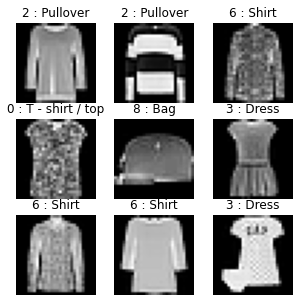

In [ ]:
dls = DataLoaders(*load_fashion_mnist(sample=200))
dls.x_name,dls.y_name = 'image','label'
dls.show_batch()

In [ ]:
class SimpleNet(nn.Module):
    '''simple net'''
    def __init__(self,in_features,hidden_features, out_features):
        super().__init__()
        self.fc1 = nn.Linear(in_features,hidden_features)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_features,out_features)

    def forward(self,x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
    
model = SimpleNet(784,64,10)
test_eq(model(first(dls.train)[dls.x_name]).shape,(64,10))

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()